In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import torch.distributions as D
import torch.nn.functional as F
from scipy.interpolate import griddata

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
print(dev)

cuda:0


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# global veriable
Uniform_low_bound = 0
Uniform_up_bound = 1
Agent_number_n = 5
number_of_groups = 2
Normal_loc = 0.5
Normal_scale = 0.2
Normal_loc1 = 0
Normal_loc2 = 1.5
Normal_scale1 = 0.5
Normal_scale2 = 0.5
Distribution_number = 10000

beta_a = 0.3
beta_b = 0.2
cauchyloc = 1.0/Agent_number_n
cauchyscalen = 0.004
kumaraswamy_a = beta_a
kumaraswamy_b = (1.0 + (beta_a - 1.0) * math.pow(
    (beta_a + beta_b - 2.0) / (beta_a - 1.0), beta_a)) / beta_a
print(kumaraswamy_b)

independentnormalloc1 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(Agent_number_n, 0, -1)]
independentnormalscale1 = [0.05 for ii in range(Agent_number_n)]

independentnormalloc2 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(1, Agent_number_n + 1, 1)]
independentnormalscale2 = [0.05 for ii in range(Agent_number_n)]
exponentialhigh = 15  #Symbol("b", real=True)
exponentiallow = 15  #Symbol("a", real=True)


order = "twopeaknormal"
# "twopeak","normal","uniform","independent1","independent2","cauchy","beta","U-exponential","arcsine"
order1name = ["dp", "random initializing", "costsharing", "heuristic"]
# "costsharing","dp","heuristic","random initializing"

0.40058530825361593


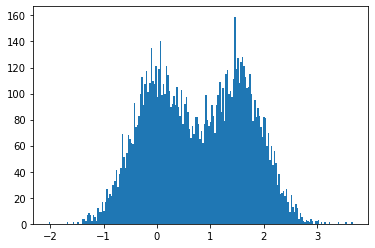

5000
[[-0.54075137  0.90906491  1.29109189  0.78386954 -0.59334917]
 [ 1.28114709  1.82504991  1.80545656 -0.54939817 -0.87342519]
 [-0.10760487  0.08323954  0.22462387 -0.42767563  0.21373625]]
5000


In [3]:
seed = 7
np.random.seed(seed)
# exec(open('distribution/twopeak.py').read())
exec(open('../distribution/twopeaknormalwithoutlimit.py').read())
# exec(open('distribution/normal.py').read())
X_train, X_test = train_test_split(value_list,
                                   test_size=0.5,
                                   random_state=seed)
# for i in range(len(value_list)):
#     for j in range(len(value_list[0])):
#         if (value_list[i][j] <= 0):
#             value_list[i][j] = 0
#         if (value_list[i][j] >= 1):
#             value_list[i][j] = 1

value_list1 = np.array(value_list)
for i in range(min(Agent_number_n, 1)):
    pa = value_list1[:, i]
    plt.hist(pa, bins=200)
    plt.show()

dataset_size = len(X_train)
print(dataset_size)
print(np.array(X_train[:3]))
print(len(X_test))
# run_cs()

In [4]:
d1 = D.normal.Normal(Normal_loc1, Normal_scale1)
d2 = D.normal.Normal(Normal_loc2, Normal_scale2)
distributionRatio1 = (d1.cdf(1) + d2.cdf(1) - d1.cdf(0) - d2.cdf(0)) / 2
distributionBase1 = d1.cdf(0) + d2.cdf(0)

d3 = D.normal.Normal(Normal_loc, Normal_scale)
distributionRatio3 = d3.cdf(1) - d3.cdf(0)
distributionBase3 = d3.cdf(0)

d4 = D.uniform.Uniform(0.0, 1.0)
distributionRatio4 = d4.cdf(1) - d4.cdf(0)
distributionBase4 = d4.cdf(0)

d5 = [
    D.normal.Normal(independentnormalloc1[ii], independentnormalscale1[ii])
    for ii in range(Agent_number_n)
]
d6 = [
    D.normal.Normal(independentnormalloc2[ii], independentnormalscale2[ii])
    for ii in range(Agent_number_n)
]

d7 = D.cauchy.Cauchy(cauchyloc, cauchyscalen)
d81 = D.exponential.Exponential(exponentiallow)
d82 = D.exponential.Exponential(exponentialhigh)

d9 = D.beta.Beta(beta_a, beta_b)
d10 = D.beta.Beta(0.5, 0.5)


def cdf(x, y, i=None):
    if (y == "twopeaknormal"):
        return (d1.cdf(x) + d2.cdf(x) ) / 2 #/ distributionRatio1
    elif (y == "normal"):
        return (d3.cdf(x) - distributionBase3) #/ distributionRatio3
    elif (y == "uniform"):
        return (d4.cdf(x) - distributionBase4) #/ distributionRatio4
    elif (y == "independent1"):
        return d5[i].cdf(x)
    elif (y == "independent2"):
        return d6[i].cdf(x)
    elif (y == "cauchy"):
        return d7.cdf(x)
    elif (y == "beta"):
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            return 1.0 - torch.pow(1.0 - torch.pow(x, kumaraswamy_a),
                                   kumaraswamy_b)
        except:
            return 1.0 - torch.pow(
                1.0 - torch.pow(torch.tensor(x, dtype=torch.float32),
                                kumaraswamy_a), kumaraswamy_b)
    elif (y == "arcsine"):
        #
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            res = 2.0 / math.pi * torch.asin(torch.sqrt(x))
            # print(x)
            return res  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
        except:
            return 2.0 / math.pi * torch.asin(
                torch.sqrt(torch.tensor(
                    x, dtype=torch.float32)))  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
    elif (y == "U-exponential"):
        return (d81.cdf(x) + (1.0 - d82.cdf(1.0 - x))) / 2

In [5]:
x=torch.nn.Parameter(torch.tensor(0.2,
                                                      requires_grad=True),
                                           requires_grad=True).cuda()
print(cdf(1.3717421124828532235939643347051, order))

print(cdf(0.5, order))

tensor(0.6979)
tensor(0.4320)


In [6]:
def bitsToPayments(bits):
    if torch.sum(bits).item() == 0:
        return bits*0
    bits = bits.type(torch.float32)
    negBits = torch.ones(Agent_number_n).cuda() - bits
    paymentBits = negBits*1000

    
    cost_sharing_payment = 1.0/torch.sum(bits).item()

    payments = bits * cost_sharing_payment
    payments += paymentBits
    
    return payments


def tpToBits(tp, bits):
    payments = bitsToPayments(bits)
    
    newBits = (tp >= payments).type(torch.uint8)
    
    
    if torch.sum(newBits).item() == 0:
        return newBits
    
    if torch.equal(newBits, bits):
        return bits
    else:
        return tpToBits(tp, newBits)


    
def tpToTotalDelay(tp, deadline, _i):
    ans = tpToBits(tp, torch.ones(Agent_number_n).type(torch.uint8).cuda())
    if(torch.sum(ans).item()==0):
        return torch.sum((1.0 - ans) * deadline), False
    else:
        return torch.sum((1.0 - ans) * deadline), True


def tpToPayments(tp):
    return bitsToPayments(tpToBits(tp,torch.ones(Agent_number_n).type(torch.uint8).cuda()))

In [7]:
def cost_sharing_with_deadline(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result

In [8]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight,
                                     gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        num_input = Agent_number_n
        num_hidden = 50
        num_output = Agent_number_n

        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.output = torch.nn.Linear(num_hidden, num_output)
        self.deadline = torch.nn.Parameter(torch.ones(Agent_number_n,
                                                      requires_grad=True),
                                           requires_grad=True).cuda()

    def forward(self, value_list):
        tensor = torch.ones(Agent_number_n, requires_grad=True)
        variable = Variable(tensor, requires_grad=True)

        h1 = torch.relu_(self.hidden_0(variable.cuda()))
        # h1 = torch.relu_(self.hidden_0(value_tensor))
        h2 = torch.relu_(self.hidden_1(h1))
        h3 = torch.relu_(self.hidden_2(h2))
        h4 = self.output(h3)  # no relu!!!!
        # torch.sigmoid(self.deadline)# need more layer
        deadline = torch.sigmoid((h4 + 1)*10)
        # deadline = torch.sigmoid(self.deadline)
        # print(deadline)
        # return

        Possible_i_list = []
        for i in range(Agent_number_n):

            Possible = 0
            for k in range(len(value_list)):
                value_tensor = value_list[k]
                test = copy.deepcopy(value_tensor)
                test_change = copy.deepcopy(test)
                test_change = deadline * test_change
                tp_0 = test_change.clone()
                tp_0[i] = 0

                judge_i = tpToTotalDelay(tp_0, deadline, i)[1]
                
#                 temp_max_delay_list,temp_sum_delay,judge_ii =  cost_sharing_with_deadline(tp_0,
#                         deadline,1.0)
#                 if (judge_i != judge_ii):
#                     print("false")
#                     return
                
                
                if (judge_i == True):
                    Possible = Possible + 1.0/len(value_list)

            Possible_i_list.append(Possible)

        temp_sum_delay_total = torch.zeros(1).cuda()
        temp_max_delay_total = torch.zeros(1).cuda()

#         print("deadline:",deadline)


        for k in range(len(value_list)):
            value_tensor = value_list[k]
            test = copy.deepcopy(value_tensor)
            test_change = copy.deepcopy(test)
            test_change = deadline * test_change

            temp_sum_delay = 0
            temp_max_delay = 0

            for i in range(Agent_number_n):
                tp_1 = test_change.clone()
                tp_1[i] = 1
                # tp_0 = copy.deepcopy(test_change_i)
                tp_0 = test_change.clone()
                tp_0[i] = 0
                offer = tpToPayments(tp_1)[i]

                Delay_1 = tpToTotalDelay(tp_1, deadline, i)[0]
                Delay_2 = tpToTotalDelay(tp_0, deadline, i)[0]

                temp = ((1.0 - cdf(offer/deadline[i], order)) * Delay_1 + cdf(
                    offer/deadline[i], order) * Delay_2)/Agent_number_n
                temp_sum_delay = temp_sum_delay + temp

#                 print("test_change",test_change)
                
#                 print("offer",offer,cdf(offer/deadline[i], order))
#                 print("temp",temp)
#                 print("Delay_1", Delay_1)
#                 print("Delay_2", Delay_2)

#                 print()
#             print("temp_sum_delay",temp_sum_delay)
#             print("test_change",test_change)
#             print("deadline",deadline)
#             print("offer",offer)
#             print("temp_sum_delay",temp_sum_delay)

#             return

            for i in range(Agent_number_n):
                Possible = Possible_i_list[i]

                temp = (1.0-deadline[i].clone()) * \
                    torch.tensor(1.0-Possible).cuda()
                temp_sum_delay = temp_sum_delay + temp

            temp_sum_delay_total = temp_sum_delay_total + temp_sum_delay

        return temp_max_delay_total, temp_sum_delay_total, deadline.cpu(
        ).data.numpy(), float(temp_sum_delay)

In [9]:
random.seed(2000)
torch.manual_seed(256)
net = Net()
# net.apply(weight_init)
#net = torch.load("Deep_learning_with_deadline_5")
net.to(dev)

#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.002)
optimizer = opt.Adam(net.parameters(), lr=0.00002)

batch_size = 32
echo = 1001

In [10]:
for i in range(int(echo)):

    # offender_types = []
    # defender_types = []
    loss_sum = 0
    denominator = 0
    """
    for j in range(batch_size):
        offender_types.append(random.randint(0, 400))
        defender_types.append(random.randint(0, 15))
    """
    X_train_list = []
    for j in range(batch_size):
        index_random = random.randint(0, len(X_train) - 1)
        X_train_list.append(
            torch.from_numpy(np.array(X_train[index_random])).cuda().type(torch.float32))
        denominator += 1

    h_delay_max, h_delay_sum, deadline_R, delay_R = net(X_train_list)
    loss_sum += h_delay_sum

    optimizer.zero_grad()
    #loss = torch.square(loss_function(loss_sum / denominator) + 52)
    loss = loss_sum / denominator

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print("i", i)
        print("batch_loss: %.2f " % float(loss_sum / denominator))
        print("value:", X_train[index_random])
        print("deadline:", deadline_R)
        #print("delay:" , delay_R)
        print()

i 0
batch_loss: 1.92 
value: [0.768561104246705, 2.009749001138648, -0.12113458701276006, -0.36801741536596483, 2.2097891230117472]
deadline: [0.99997115 0.9999707  0.99991417 0.999382   0.9998211 ]

i 100
batch_loss: 1.64 
value: [2.1281031462717097, 0.08802041443790723, 1.2188897252174868, -0.003664706145082679, 0.5825329245897476]
deadline: [0.9999677  0.9999714  0.99991715 0.99889815 0.9997677 ]

i 200
batch_loss: 1.76 
value: [-0.07206245519864385, 1.2539247060336085, 1.784232367092181, 1.5717464117374198, 0.7361397986505678]
deadline: [0.9999633  0.9999716  0.99992836 0.9972473  0.99966335]

i 300
batch_loss: 1.92 
value: [2.595440852549377, 1.26368289247057, 1.1552250709982659, -0.4196170869829145, 1.1024178618924847]
deadline: [0.99995184 0.9999716  0.99994576 0.9881275  0.9993717 ]

i 400
batch_loss: 1.98 
value: [1.675525509008411, -0.08927353505497569, 0.10582815827023256, 1.908605426594495, 2.122497986638227]
deadline: [0.99990237 0.9999716  0.99996495 0.8150456  0.99808156

In [11]:
print("batch: %.2f " % float(loss_sum / denominator))
print("value:", X_train[index_random])
print("deadline:", deadline_R)
print("delay:", delay_R)



batch: 2.03 
value: [1.4797302619344581, 2.102832874663478, 1.9728037580093292, 2.1891901146935573, 0.8887218574282912]
deadline: [9.6457821e-01 9.9432462e-01 9.9999547e-01 2.2848164e-04 1.0086472e-02]
delay: 0.7535333037376404


In [12]:
def cost_sharing_with_deadline_old(test, t_c, target):
    temp_max_delay_list = [0 for i in range(len(test))]
    temp_sum_delay = 0
    result = False
    for k in range(len(test), 0, -1):
        count = 0
        delay = 0
        for ii in range(len(test)):
            item = test[ii]
            if (item + 1e-4 >= target / k):
                count += 1
            else:
                delay += t_c[ii]
                temp_max_delay_list[ii] = t_c[ii]

        if (count >= k):
            temp_sum_delay += delay
            result = True
            break
        if (k <= 1):
            # print(test,number_n);
            temp_max_delay_list = t_c
            temp_sum_delay = sum(t_c)
            result = False

    return temp_max_delay_list, temp_sum_delay, result


# Cost Sharing
def run_cs_old(deadline_list):
    sum_delay = 0
    max_delay = 0
    test_number = 0
    for i in range(len(X_test)):
        test_number += 1
        temp_max_delay = 0
        temp_delay = 0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change = []

        for j in range(len(test)):
            test_change.append(test[j] * deadline_list[j])

        temp_max_delay_list, temp_sum_delay, judge1 = cost_sharing_with_deadline_old(
            test_change, copy.deepcopy(deadline_list), 1.0)
        for j in range(len(test_change)):
            test_i = copy.deepcopy(test_change)
            test_i = np.delete(test_i, j)

            deadline_i = copy.deepcopy(deadline_list)
            deadline_i = np.delete(deadline_i, j)

            temp_max_delay_i_list, temp_sum_delay_i, judge_i = cost_sharing_with_deadline_old(
                test_i, deadline_i, 1.0)

            if (judge_i == False):
                temp_sum_delay += (1.0 - deadline_list[j])
                temp_max_delay_list[j] += (1.0 - deadline_list[j])

        max_delay += max(temp_max_delay_list)

        sum_delay += temp_sum_delay

#     print("deadline: ", deadline_list)
#     print("sum_delay: ", sum_delay / test_number)
#     print("max_delay: ", max_delay / test_number)
#     print()
    return max_delay / test_number, sum_delay / test_number


print(run_cs_old(deadline_R))

(0.756306161060743, 1.6461937982323522)


In [13]:
torch.save(net, "Deep_learning_with_deadline_3")

In [14]:
import time
class Foo(object):

    def __init__(self, test_item, test_change_item, deadline):
        self.test_item = test_item
        self.test_change_item = test_change_item
        self.deadline = deadline

    def __lt__(self, other):
        return self.test_change_item < other.test_change_item
def cost_sharing_with_deadline_free(n,_i,numbers_of_people_will_pay,started_k):
    
    for k in range(started_k,0,-1):
        if(n-_i<=k):
            x=k-1
        else:
            x=k
        #print(n,_i,x,numbers_of_people_will_pay[x],k)
        if(numbers_of_people_will_pay[x]>=k):
            return True,k
    return False,0
#Cost Sharing
def run_cs_test(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_test)):
#        if(i%1000==0):
#            seconds=time.time()
#            print("times: ",seconds-seconds_start)
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change_temp = []
        Foo_list = []
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        
        for j in range(len(test)):
            test_change_temp.append(test[j] * deadline_list[j])
            Foo_list.append(Foo(test[j],test_change_temp[j],deadline_list[j]))
            
        Foo_list.sort(reverse=False)
        

        for j in range(len(test)):
            test[j]=Foo_list[j].test_item
            test_change_temp[j]=Foo_list[j].test_change_item
            deadline_list[j]=Foo_list[j].deadline

        test_change = copy.deepcopy(test_change_temp);
        
        numbers_of_people_will_pay = [-10 for ii in range(len(test_change)+2)]#pay 1/k
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        k = 1
        started=len(test_change)-1
        end_k=-10
        for j in range(len(test_change)):
            if(k<=len(test_change)):
                for people_id in range(started,-1,-1):
                    if(test_change[people_id]+1e-9>=1.0/k):
                        started=people_id
                        numbers_of_people_will_pay[k]=len(test_change)-people_id
                        end_k=len(test_change)-people_id
                    else:
                        k+=1
                        break;
                    
        for j in range(k,len(test_change)+1):
            numbers_of_people_will_pay[j]=end_k
            
        deadlist_new=copy.deepcopy(deadline_list)
        
        temp_max_delay_list,temp_sum_delay,judge_i =  cost_sharing_with_deadline(test_change,
                        deadlist_new,1.0)
        
        judge_i= True
        started_k = len(test)
        for _i in range(len(test_change)):
            if judge_i:
                judge_i,started_k =  cost_sharing_with_deadline_free(len(test_change),
                    _i,numbers_of_people_will_pay,started_k)
                
                
            started_k+=1
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[_i])
                temp_max_delay_list[_i] += (1.0-deadline_list[_i])
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
                

    return max_delay/test_number,sum_delay/test_number

    
print("test:",run_cs_test(deadline_R))

test: (0.7531167202478275, 1.657338618390719)


In [15]:
list_1=[]
list_2=[]
list_3=[]
for i in range(1,101):
    x=float(i)/100
    xx=[x for i in range(Agent_number_n)]
    #print(xx)
    res1,res2=run_cs_test(xx)
    list_1.append(res1)
    list_2.append(res2)
    list_3.append(x)
print("max_delay:",min(list_1),"deadline:",list_3[list_1.index(min(list_1))])
print("sum_dealy:",min(list_2),"deadline:",list_3[list_2.index(min(list_2))])

max_delay: 0.5772700000000397 deadline: 0.51
sum_dealy: 1.7495560000000987 deadline: 0.77


In [16]:
print("target:",order)
print("sum_delay")
print("NN:",run_cs_old(deadline_R)[1],"one_deadline:",min(list_2))
print("{:.4%}".format(run_cs_test(deadline_R)[1]/min(list_2)))

target: twopeaknormal
sum_delay
NN: 1.6601738025655766 one_deadline: 1.7495560000000987
94.7082%


In [17]:
print("max_delay")
print("NN:",run_cs_old(deadline_R)[0],"one_deadline:",min(list_1))
print("{:.4%}".format(run_cs_test(deadline_R)[0]/min(list_1)))

max_delay
NN: 0.7554910493602977 one_deadline: 0.5772700000000397
130.4077%
